In [ ]:
import os, sys

%load_ext autoreload
%autoreload 2

current = os.path.dirname(os.path.realpath("*.ipynb"))
parent = os.path.dirname(current)
sys.path.append(parent)
%cd ..

In [2]:
# !python mnist.py --num-epochs 10 

In [ ]:
from mnist import *

In [4]:
device = torch.device(
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)

# data loaders
train_data = datasets.MNIST(
    root='data', download=True, train=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(
    root='data', download=True, train=False, transform=transforms.ToTensor())

In [6]:
# apply PCA to the dataset (as done in the paper)
X_train = train_data.data.reshape(len(train_data), -1)
X_test = test_data.data.reshape(len(test_data), -1)

A = torch.cat([X_train, X_test]).float()

In [7]:
_, _, V = torch.pca_lowrank(A, q=60)
V.shape

torch.Size([784, 60])

In [8]:
res = torch.matmul(A, V)
res.shape

torch.Size([70000, 60])

In [9]:
X_train_pca_tensor = res[:60000]
X_test_pca_tensor = res[60000:]
y_train = train_data.targets
y_test = test_data.targets

# create torch datasets
train_dataset = TensorDataset(X_train_pca_tensor, y_train)
test_dataset = TensorDataset(X_test_pca_tensor, y_test)

In [13]:
# training settings
lot_size = 600

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=lot_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=lot_size, shuffle=False)

model = LinearNet(in_features=60, hidden=1000).to(device)

# loss function
criterion = nn.CrossEntropyLoss()

lr = 0.001
num_epochs = 2

# differentially private optimizer
optimizer = optim.PIAdam(model.named_parameters(), lot_size, lr=lr, noise_scale=4, max_grad_norm=4)

num_batches = len(train_loader)

logger = {'loss': [], 'total_loss': [], 'accuracy': [], 'total_accuracy': [], 'total_val_accuracy': []}

In [14]:
train_dp_model(model, criterion, optimizer, num_epochs, train_loader, test_loader, device=device,
               logger=logger)

Epoch 1/2, Step 1/100, Train Acc: 0.1333
Epoch 1/2, Step 2/100, Train Acc: 0.2233
Epoch 1/2, Step 3/100, Train Acc: 0.3600
Epoch 1/2, Step 4/100, Train Acc: 0.4717
Epoch 1/2, Step 5/100, Train Acc: 0.5633
Epoch 1/2, Step 6/100, Train Acc: 0.6250
Epoch 1/2, Step 7/100, Train Acc: 0.6000
Epoch 1/2, Step 8/100, Train Acc: 0.6017
Epoch 1/2, Step 9/100, Train Acc: 0.6850
Epoch 1/2, Step 10/100, Train Acc: 0.7333
Epoch 1/2, Step 11/100, Train Acc: 0.7883
Epoch 1/2, Step 12/100, Train Acc: 0.8400
Epoch 1/2, Step 13/100, Train Acc: 0.8533
Epoch 1/2, Step 14/100, Train Acc: 0.8383
Epoch 1/2, Step 15/100, Train Acc: 0.8600
Epoch 1/2, Step 16/100, Train Acc: 0.8383
Epoch 1/2, Step 17/100, Train Acc: 0.8367
Epoch 1/2, Step 18/100, Train Acc: 0.8967
Epoch 1/2, Step 19/100, Train Acc: 0.8933
Epoch 1/2, Step 20/100, Train Acc: 0.8817
Epoch 1/2, Step 21/100, Train Acc: 0.8750
Epoch 1/2, Step 22/100, Train Acc: 0.8917
Epoch 1/2, Step 23/100, Train Acc: 0.9100
Epoch 1/2, Step 24/100, Train Acc: 0.8817
E

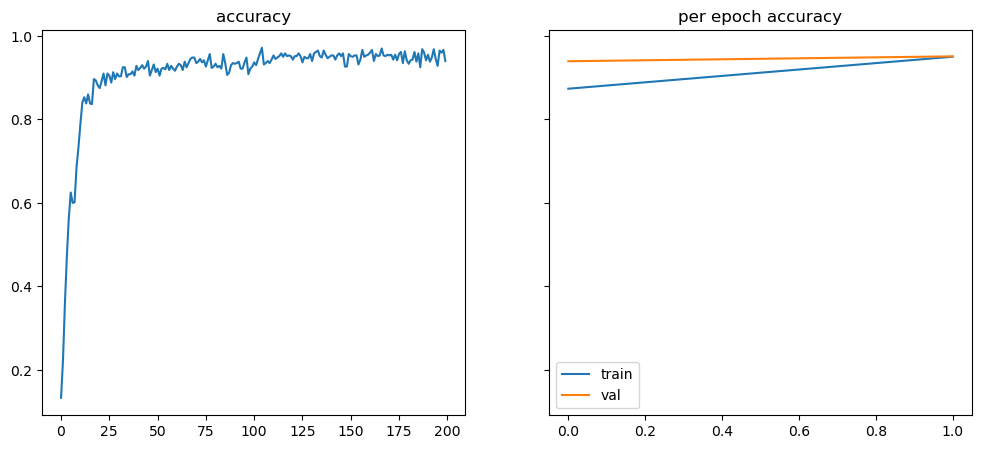

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

ax[0].plot(logger['accuracy'])
ax[0].set_title('accuracy')

ax[1].plot(logger['total_accuracy'], label='train')
ax[1].set_title('per epoch accuracy')
ax[1].plot(logger['total_val_accuracy'], label='val')
ax[1].legend()
plt.show()